<a href="https://colab.research.google.com/github/DJCordhose/ux-by-tfjs/blob/master/notebooks/rnn-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Mouse-Movements on the Server

In [1]:
# for colab
# !pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.executing_eagerly()

True

## load data

In [7]:
import pandas as pd
print(pd.__version__)

0.23.4


In [8]:
df = pd.read_json('../data/sample2.json', typ='series')

In [9]:
len(df)

202

In [10]:
df.head()

0    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
1    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
2    {'x': [[796, 199, -18, 12, 8], [789, 203, -14,...
3    {'x': [[760, 232, 6, -4, 8], [763, 230, 6, -4,...
4    {'x': [[680, 280, 40, -30, 8], [714, 263, 68, ...
dtype: object

In [11]:
X = [item['x'] for item in df]

In [12]:
X[0]

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0,

In [13]:
y = [item['y'] - 1 for item in df]

In [14]:
y[0]

0

In [15]:
from math import floor

def make_chunks(list_to_chunk, chunk_size):
    length = len(list_to_chunk)
    assert length / chunk_size == floor(length / chunk_size), "length of data must be multiple of segment length"
    for chunk_start in range(0, length, chunk_size):
        yield list_to_chunk[chunk_start : chunk_start + chunk_size]

In [16]:
import numpy as np

CHUNK_SIZE = 25
# only use the final segments 
SEGMENTS = 2

X_expanded = []
y_expanded = []

for x_el, y_el in zip(X, y):
    chunks = list(make_chunks(x_el, CHUNK_SIZE))
    chunks = chunks[len(chunks) - SEGMENTS:]
    labels = [y_el] * SEGMENTS
    for seq, label in zip(chunks, labels):
        X_expanded.append(seq)
        y_expanded.append(label)

X_expanded = np.array(X_expanded)
y_expanded = np.array(y_expanded)

In [17]:
X_expanded.shape

(404, 25, 5)

In [18]:
X_expanded[100]

array([[861, 241,   8,   8,   7],
       [866, 244,  10,   6,   8],
       [869, 248,   6,   8,   6],
       [873, 251,   8,   6,   8],
       [876, 254,   6,   6,   7],
       [878, 257,   4,   8,   7],
       [881, 260,   6,   6,   7],
       [883, 263,   4,   4,   7],
       [884, 265,   2,   4,   7],
       [886, 267,   4,   4,   7],
       [887, 268,   2,   4,   7],
       [888, 270,   2,   4,   9],
       [889, 273,   2,   4,   6],
       [890, 275,   2,   4,   8],
       [892, 277,   4,   6,   6],
       [894, 281,   4,   6,   7],
       [896, 285,   4,   8,   8],
       [899, 289,   6,  10,   8],
       [902, 294,   6,  10,   6],
       [903, 298,   2,   6,   8],
       [905, 301,   4,   8,   7],
       [907, 304,   4,   6,   7],
       [908, 306,   2,   2,   6],
       [910, 307,   4,   4,   8],
       [911, 309,   2,   2,   9]])

In [19]:
X_expanded[100][0]

array([861, 241,   8,   8,   7])

In [20]:
y_expanded[100]

2

In [21]:
np.unique(y_expanded)

array([0, 1, 2])

In [22]:
assert np.array_equal(np.unique(y_expanded), [0, 1, 2])

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential, Model

In [24]:
n_steps = len(X_expanded[0])
n_features = len(X_expanded[0][0])
n_buttons = 3

model = Sequential()
model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input", 
# recurrent_dropout makes things slow              
#               dropout=0.1, recurrent_dropout=0.1))
                dropout=0.1))
# model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(BatchNormalization())
model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

W0402 11:59:04.875766 18560 deprecation.py:506] From C:\Users\olive\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
%%time

EPOCHS = 500
BATCH_SIZE = 200

history = model.fit(X_expanded, y_expanded, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

Wall time: 13.9 s


In [26]:
loss, accuracy = model.evaluate([X_expanded], y_expanded, batch_size=BATCH_SIZE)
accuracy

404/404 [==============================] - 0s 37us/sample - loss: 0.6004 - accuracy: 0.8762


0.87623763

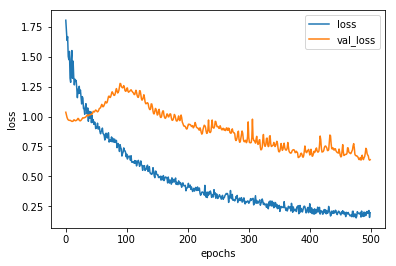

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

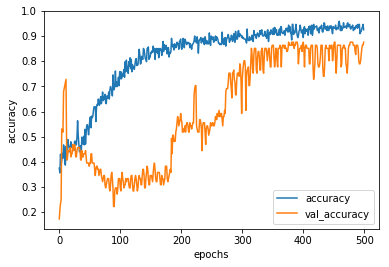

In [28]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])

In [29]:
model.predict([[X_expanded[0]]])

array([[0.60437876, 0.3832703 , 0.01235094]], dtype=float32)

In [30]:
model.predict([[X_expanded[0]]]).argmax()

0

In [31]:
y_expanded[0]

0

In [32]:
model.save('ux.hd5')